# Descrição de Atividade

Nessa atividade você irá usar seus conhecimentos sobre classificação para prever quais candidatos à Câmara de Deputados foram eleitos nas eleições de 2014. De forma específica:

 1. Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (1 pt.)
 2. Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.  (2 pts.)
Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta. (2 pt.)
 3. Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo?  (2 pts.)
 4. Envie seus melhores modelos à competição do Kaggle. Faça pelo menos uma submissão. Sugestões para melhorar o modelo: (2 pts.)
 5. Experimente outros modelos (e.g. SVM, RandomForests e GradientBoosting).
 6. Experimente outras estratégias de ensembles (e.g. Stacking).
 7. Experimente balancear as classes,  caso estejam desbalanceadas.

Os dados estão neste link: https://www.kaggle.com/c/ufcg-cdp-20182-lab3/data (Links para um site externo)Links para um site externo

Para a entrega envie o link no GitHub com o notebook usado para resolver o Lab.


### Descrição dos dados:

Os dados utilizados correspondem aos das eleições de Deputado Federal nos anos de 2006, 2010 e 2014. Estão dividos nas seguintes colunas:

* **ano**: Ano da eleição;
* **sequencial_candidato**: O identificador do candidato. Corresponde à coluna Id do arquivo de submissão;
* **nome**: Nome do candidato;
* **uf**: Sigla do estado do candidato;
* **partido**: Partido do candidato;
* **quantidade_doacoes**: Número de doações que um candidato recebeu;
* **quantidade_doadores**: Numero de doadores que um candidato teve;
* **total_receita**: Total de receita de um candidato;
* **media_receita**: Média da receita de um candidato;
* **recursos_de_outros_candidatos.comites**: Total de receita proveniente de outros candidatos e comitês;
* **recursos_de_pessoas_fisicas**: Total de receita proveniente de pessoas físicas;
* **recursos_de_pessoas_juridicas**: Total de receita proveniente de pessoas juridicas;
* **recursos_proprios**:Total de receita proveniente dos próprios candidatos;
* **recursos_de_partido_politico**: Total de receita proveniente do partido do candidato;
* **quantidade_despesas**: Número de despesas que um candidato teve;
* **quantidade_fornecedores**: Número de fornecedores que um candidato teve;
* **total_despesa**: Total de depesa de um candidato;
* **media_despesa**: Média da despesa de um candidato;
* **cargo**: Cargo ao qual o candidato está concorrendo;
* **sexo**: Sexo do candidato;
* **grau**: Grau de escolaridade do candidato;
* **estado_civil**: Estado civil do candidato;
* **ocupacao**: Ocupação do candidato;
* **situacao**: Situação final do candidato. Corresponde à coluna **Predict** do arquivo de submissão;

## Import Libraries

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.externals.joblib import Parallel, delayed

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN

from collections import Counter

from enum import Enum

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

py.init_notebook_mode(connected=True)

sns.set(style="ticks")

## Load Data

In [3]:
train_df = pd.read_csv('../data/assignment_4/train.csv')
test_df = pd.read_csv('../data/assignment_4/test.csv')

data = pd.concat([train_df, test_df], sort=False)

data.set_index('sequencial_candidato', inplace=True, drop=True)

## Preprocess Data

In [4]:
data.drop(columns=['nome'], inplace=True)

In [5]:
qt = QuantileTransformer(random_state=2, output_distribution='normal')

skewed_features = ['quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos.comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'recursos_de_partido_politico',
       'quantidade_despesas', 'quantidade_fornecedores', 'total_despesa',
       'media_despesa']

data[skewed_features] = qt.fit_transform(X=data[skewed_features])

In [6]:
cleanup_nums = {"grau" : {"LÊ E ESCREVE": 1, 
                       "ENSINO FUNDAMENTAL INCOMPLETO":2, 
                       "ENSINO FUNDAMENTAL COMPLETO":3, 
                       "ENSINO MÉDIO INCOMPLETO":4,
                       "ENSINO MÉDIO COMPLETO":5,
                       "SUPERIOR INCOMPLETO":6,
                       "SUPERIOR COMPLETO": 7}}

data.replace(cleanup_nums, inplace=True)
data["grau"] = pd.to_numeric(data["grau"])

In [7]:
categorical_feats = [col for col in data.columns if not np.issubdtype(data[str(col)].dtype, np.number) and col not in ['nome', 'situacao']]

data = pd.get_dummies(data, columns=categorical_feats)
data.shape

(12214, 258)

## Split Data into Train and Test

In [8]:
data['situacao_dummy'] = data['situacao'].map({'eleito': 1, 'nao_eleito': 0})

train = data[(data.ano == 2006) | (data.ano == 2010)]
test = data[data.ano == 2014]

print(train.shape)
print(test.shape)

(7622, 259)
(4592, 259)


## Target Class Imbalancing

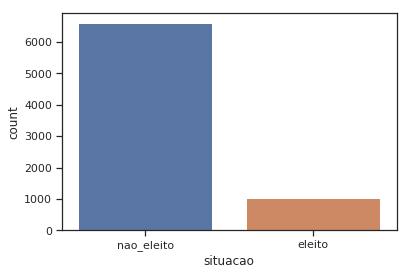

In [9]:
sns.countplot(x='situacao', data=train)

In [10]:
num_elected_candidates = train.situacao[train.situacao == 'eleito'].count()
num_not_elected_candidates = train.situacao[train.situacao == 'nao_eleito'].count()
total_candidates = train.shape[0]

print("Número de candidatos Eleitos: {}".format(num_elected_candidates))
print("Número de candidatos Não-Eleitos: {}".format(num_not_elected_candidates))
print("Total de candidatos: {}\n".format(total_candidates))

print("Proporção de candidatos eleitos: {:2.2%}".format((num_elected_candidates/total_candidates)))
print("Proporção de candidatos não-eleitos: {:2.2%}".format((num_not_elected_candidates/total_candidates)))

Número de candidatos Eleitos: 1026
Número de candidatos Não-Eleitos: 6596
Total de candidatos: 7622

Proporção de candidatos eleitos: 13.46%
Proporção de candidatos não-eleitos: 86.54%


A variável alvo **situacao** é bastante _desbalanceada_, em uma proporção de aproximadamente 1 eleito para cada 6 não-eleitos. Precisamente 13.46% dos candidatos foram eleitos, enquanto 86.54% não foram eleitos.

Esse desbalanceamento pode causar alguns efeitos colaterais na classificação feita pelo modelo preditor, tais como overfitting do modelo em relação à classe majoritária, o que prejudica a acurácia da predição, podendo causar até mesmo a interpretação incorreta dos resultados se o desbalanceamento não for endereçado corretamente.

Existem algumas práticas que podemos adotar para corrigir e lidar com esse desbalanceamento, a saber:

* Coleta de mais dados, que poderia rebalancear as classes, a depender da natureza do problema;
* Mudar a forma de amostragem do dataset, a qual pode estar gerando uma amostra desbalanceada, contudo o dataset não está desbalanceado;
* Usar alguma forma de gerar dados sintéticos como Synthetic Minority Over-sampling Technique [SMOTE](https://imbalanced-learn.org/en/stable/over_sampling.html#cbhk2002) e Adaptive Synthetic [ADASYN](https://imbalanced-learn.org/en/stable/over_sampling.html#hbgl2008);
* Incorporar algum modelo que tem uma forma de penalização para compensar o desbalanceamento de classes a exemplo de penalized-LDA e penalized-SVM.


Para essa atividade nós usaremos a técnica de geração de dados sintéticos SMOTE.

In [11]:
train.drop(['situacao'], axis=1, inplace=True)

X = train.loc[:, train.columns != 'situacao_dummy']
y = train.situacao_dummy

X_train, y_train = SMOTE().fit_resample(X, y)
print("SMOTE: {}".format(sorted(Counter(y_train).items())))

/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



SMOTE: [(0.0, 6596), (1.0, 6596)]


## Split Train and Validation

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train: {}".format(X_train.shape, y_train.shape))
print("Test: {}".format(X_test.shape, y_test.shape))

Train: (10553, 257)
Test: (2639, 257)


## Modelos

In [76]:
class ModelsPaths(Enum):
    KNR_PATH = 'assignment4-models/knr.p'
    LR_PATH = 'assignment4-models/lr.p'
    DT_PATH = 'assignment4-models/dt.p'
    ADA_PATH = 'assignment4-models/ada.p'
    RF_PATH = 'assignment4-models/rf.p'
    ET_PATH = 'assignment4-models/et.p'
    SVC_PATH = 'assignment4-models/svc.p'
    LGBM_PATH = 'assignment4-models/lgbm.p'
    CAT_PATH = 'assignment4-models/cat.p'
    XGB_PATH = 'assignment4-models/xgb.p'

class ModelsNames(Enum):
    LR = 'Logistic Regression'
    DT = 'Decision Trees'
    ET = 'Extra Trees'
    RF = 'Random Forest'
    ADA = 'AdaBoost'
    SVC = 'Support Vector Machine'
    LGBM = 'LGBM'
    CAT = 'CatBoost'
    XGB = 'XGBoost'
    KNR = 'KNR'

#### Auxiliary Functions

In [99]:
def report_cross_validation_results(model):
    print('(Cross-)Validation set evaluation')
    
    report_val = {}
    scoring = ['precision','recall','f1','accuracy', 'roc_auc']
    for sc in scoring:
        cv = StratifiedKFold(shuffle=True, random_state=42, n_splits=10)
        report_val[sc] = cross_val_score(model, X_train, y_train, cv=cv, scoring=sc, n_jobs=-1).mean()
    
    for key, val in report_val.items():
        print('{} score - validation set: {:.4}'.format(key.capitalize(), val))
    

def report_results_with_test_set(model):
    print('----------------------')
    print('Test set evaluation:')

    y_pred_test = model.predict(X_test)
    
    report_test = {}
    report_test['precision'] = precision_score(y_test, y_pred_test)
    report_test['recall'] = recall_score(y_test, y_pred_test)
    report_test['f1'] = f1_score(y_test, y_pred_test)
    report_test['accuracy'] = accuracy_score(y_test, y_pred_test)
    report_test['roc_auc'] = roc_auc_score(y_test, y_pred_test)
    
    for key, val in report_test.items():
        print('{} score - test set: {:.4}'.format(key.capitalize(), val))

    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, y_pred_test))

    
def save_trained_model(model, path):
    pickle.dump(model, open(path.value, 'wb'))

def load_trained_model(path):
    return pickle.load(open(path.value, 'rb'))

def _get_top_10_features_and_imps(f_names, f_imps):
    aux = [(f_name, f_imp) for f_idx_a, f_name in f_names for f_idx_b, f_imp in f_imps if f_idx_a == f_idx_b]
    aux.sort(key=lambda tup: -tup[1]) # sort by feature_importance, descending order

    top_10_features = aux[:10]
    features_names = [x for x,_ in top_10_features]
    features_imps = [y for _,y in top_10_features]
    
    return (features_names, features_imps)

def _get_feat_names_and_imps_1(model):
    f_names = [(f_idx, f_name) for f_idx, f_name in enumerate(train.columns)]
    f_imps = [(f_idx, f_imp) for f_idx, f_imp in enumerate(model.feature_importances_)]

    return _get_top_10_features_and_imps(f_names, f_imps)

def _get_feat_names_and_imps_2(model):
    imps = (np.std(X_train, 0) * lr_.coef_)[0]
    
    f_names = [(f_idx, f_name) for f_idx, f_name in enumerate(train.columns)]
    f_imps = [(f_idx, f_imp) for f_idx, f_imp in enumerate(imps)]
    
    return _get_top_10_features_and_imps(f_names, f_imps)

    
def _plot_graph(model_name, features_names, features_imps):
    # Scatter plot 
    trace = go.Scatter(
        y = features_imps,
        x = features_names,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 25,
            color = features_imps,
            colorscale='Portland',
            showscale=True
        ),
        text = features_names
    )
    data = [trace]

    layout= go.Layout(
        autosize= True,
        title= '{} Feature Importance'.format(model_name.value),
        hovermode= 'closest',
        yaxis=dict(
            title= 'Feature Importance',
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='scatter2010')


def plot_feature_importances(model, model_name):
    feature_names, feature_imps = None,None
    
    if model_name in [ModelsNames.DT, ModelsNames.ET, ModelsNames.RF, ModelsNames.ADA]:
        feature_names, feature_imps = _get_feat_names_and_imps_1(model)
    elif model_name in [ModelsNames.LR]:
        feature_names, feature_imps = _get_feat_names_and_imps_2(model)
    
    _plot_graph(model_name, feature_names, feature_imps)

### Models

#### **_KNN (K-Nearest Neighbors)_**

In [14]:
knr = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)

report_cross_validation_results(knr)
report_results_with_test_set(knr)
save_trained_model(knr, ModelsPaths.KNR_PATH)

(Cross-)Validation set evaluation
Precision score - validation set: 0.8735
Recall score - validation set: 0.9979
F1 score - validation set: 0.9315
Accuracy score - validation set: 0.9268
Roc_auc score - validation set: 0.9573
----------------------
Test set evaluation:
Precision score - test set: 0.8869
Recall score - test set: 0.9993
F1 score - test set: 0.9397
Accuracy score - test set: 0.9348
Roc_auc score - test set: 0.9337

Confusion Matrix:
[[1126  171]
 [   1 1341]]


#### **_Logistic Regression_**

In [15]:
lr = LogisticRegression(random_state=42).fit(X_train, y_train)

report_cross_validation_results(lr)
report_results_with_test_set(lr)
save_trained_model(lr, ModelsPaths.LR_PATH)

/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(Cross-)Validation set evaluation
Precision score - validation set: 0.9045
Recall score - validation set: 0.9646
F1 score - validation set: 0.9335
Accuracy score - validation set: 0.9316
Roc_auc score - validation set: 0.9685
----------------------
Test set evaluation:
Precision score - test set: 0.9064
Recall score - test set: 0.9672
F1 score - test set: 0.9358
Accuracy score - test set: 0.9326
Roc_auc score - test set: 0.9319

Confusion Matrix:
[[1163  134]
 [  44 1298]]


#### _**Decision Tree Classifier**_

In [45]:
dt = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)

report_cross_validation_results(dt)
report_results_with_test_set(dt)
save_trained_model(dt, ModelsPaths.DT_PATH)

(Cross-)Validation set evaluation
Precision score - validation set: 0.9294
Recall score - validation set: 0.9433
F1 score - validation set: 0.9362
Accuracy score - validation set: 0.936
Roc_auc score - validation set: 0.9361
----------------------
Test set evaluation:
Precision score - test set: 0.927
Recall score - test set: 0.9456
F1 score - test set: 0.9362
Accuracy score - test set: 0.9344
Roc_auc score - test set: 0.9343

Confusion Matrix:
[[1197  100]
 [  73 1269]]


#### **_Adaboost Ensemble_**

In [46]:
ada = AdaBoostClassifier(random_state=42, learning_rate=0.01).fit(X_train, y_train)

report_cross_validation_results(ada)
report_results_with_test_set(ada)
save_trained_model(ada, ModelsPaths.ADA_PATH)

(Cross-)Validation set evaluation
Precision score - validation set: 0.8713
Recall score - validation set: 0.9614
F1 score - validation set: 0.914
Accuracy score - validation set: 0.9099
Roc_auc score - validation set: 0.9273
----------------------
Test set evaluation:
Precision score - test set: 0.8737
Recall score - test set: 0.9687
F1 score - test set: 0.9187
Accuracy score - test set: 0.9128
Roc_auc score - test set: 0.9119

Confusion Matrix:
[[1109  188]
 [  42 1300]]


#### **_Random Forest Classifier_**

In [47]:
rf = RandomForestClassifier(random_state = 42).fit(X_train, y_train)

report_cross_validation_results(rf)
report_results_with_test_set(rf)
save_trained_model(rf, ModelsPaths.RF_PATH)

(Cross-)Validation set evaluation


/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Precision score - validation set: 0.9342
Recall score - validation set: 0.9652
F1 score - validation set: 0.9494
Accuracy score - validation set: 0.9487
Roc_auc score - validation set: 0.9859
----------------------
Test set evaluation:
Precision score - test set: 0.9316
Recall score - test set: 0.9642
F1 score - test set: 0.9476
Accuracy score - test set: 0.9458
Roc_auc score - test set: 0.9455

Confusion Matrix:
[[1202   95]
 [  48 1294]]


#### **_Extra Trees Classifier_**

In [48]:
et = ExtraTreesClassifier(random_state=42).fit(X_train, y_train)

report_cross_validation_results(et)
report_results_with_test_set(et)
save_trained_model(et, ModelsPaths.ET_PATH)

/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



(Cross-)Validation set evaluation
Precision score - validation set: 0.9441
Recall score - validation set: 0.985
F1 score - validation set: 0.9641
Accuracy score - validation set: 0.9634
Roc_auc score - validation set: 0.9914
----------------------
Test set evaluation:
Precision score - test set: 0.9436
Recall score - test set: 0.9851
F1 score - test set: 0.9639
Accuracy score - test set: 0.9625
Roc_auc score - test set: 0.9621

Confusion Matrix:
[[1218   79]
 [  20 1322]]


#### **_Support Vector Classifier_**

In [25]:
svc = SVC(random_state=42, probability=True).fit(X_train, y_train)

report_cross_validation_results(svc)
report_results_with_test_set(svc)
save_trained_model(svc, ModelsPaths.SVC_PATH)

/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(Cross-)Validation set evaluation
Precision score - validation set: 0.8968
Recall score - validation set: 0.9739
F1 score - validation set: 0.9337
Accuracy score - validation set: 0.9311
Roc_auc score - validation set: 0.9714
----------------------
Test set evaluation:
Precision score - test set: 0.8959
Recall score - test set: 0.9747
F1 score - test set: 0.9336
Accuracy score - test set: 0.9295
Roc_auc score - test set: 0.9287

Confusion Matrix:
[[1145  152]
 [  34 1308]]


#### **_Gradient Boosting Classifier - LightGBM_**

In [26]:
lgbm = LGBMClassifier(silent=1, random_state=42, learning_rate=0.1).fit(X_train, y_train)

report_cross_validation_results(lgbm)
report_results_with_test_set(lgbm)
save_trained_model(lgbm, ModelsPaths.LGBM_PATH)

(Cross-)Validation set evaluation
Precision score - validation set: 0.9457
Recall score - validation set: 0.9692
F1 score - validation set: 0.9572
Accuracy score - validation set: 0.9569
Roc_auc score - validation set: 0.9939
----------------------
Test set evaluation:
Precision score - test set: 0.9472
Recall score - test set: 0.9762
F1 score - test set: 0.9615
Accuracy score - test set: 0.9602
Roc_auc score - test set: 0.9599

Confusion Matrix:
[[1224   73]
 [  32 1310]]


#### **_Gradient Boosting Classifier - CatBoost_**

In [27]:
cat = CatBoostClassifier(random_state=42, learning_rate=0.5, allow_writing_files=False, verbose=0, iterations=200, depth=3).fit(X_train, y_train)

report_cross_validation_results(cat)
report_results_with_test_set(cat)
save_trained_model(cat, ModelsPaths.CAT_PATH)

(Cross-)Validation set evaluation
Precision score - validation set: 0.9423
Recall score - validation set: 0.9608
F1 score - validation set: 0.9514
Accuracy score - validation set: 0.9511
Roc_auc score - validation set: 0.9916
----------------------
Test set evaluation:
Precision score - test set: 0.9445
Recall score - test set: 0.9642
F1 score - test set: 0.9543
Accuracy score - test set: 0.953
Roc_auc score - test set: 0.9528

Confusion Matrix:
[[1221   76]
 [  48 1294]]


#### **_Gradient Boosting Classifier - XGBoost_**

In [28]:
xgb = XGBClassifier(learning_rate=0.1, silent=1, seed=42).fit(X_train, y_train)

report_cross_validation_results(xgb)
report_results_with_test_set(xgb)
save_trained_model(xgb, ModelsPaths.XGB_PATH)

(Cross-)Validation set evaluation
Precision score - validation set: 0.9271
Recall score - validation set: 0.9735
F1 score - validation set: 0.9497
Accuracy score - validation set: 0.9486
Roc_auc score - validation set: 0.9896
----------------------
Test set evaluation:
Precision score - test set: 0.9221
Recall score - test set: 0.9791
F1 score - test set: 0.9498
Accuracy score - test set: 0.9473
Roc_auc score - test set: 0.9468

Confusion Matrix:
[[1186  111]
 [  28 1314]]


## Feature Importances Plots

Abaixo listamos as 10 features mais importantes elencadas por diferentes modelos que usamos, após o treinamento destes.

### Decision Tress, AdaBoost, Random Forest Classifier e Extra Trees Classifier

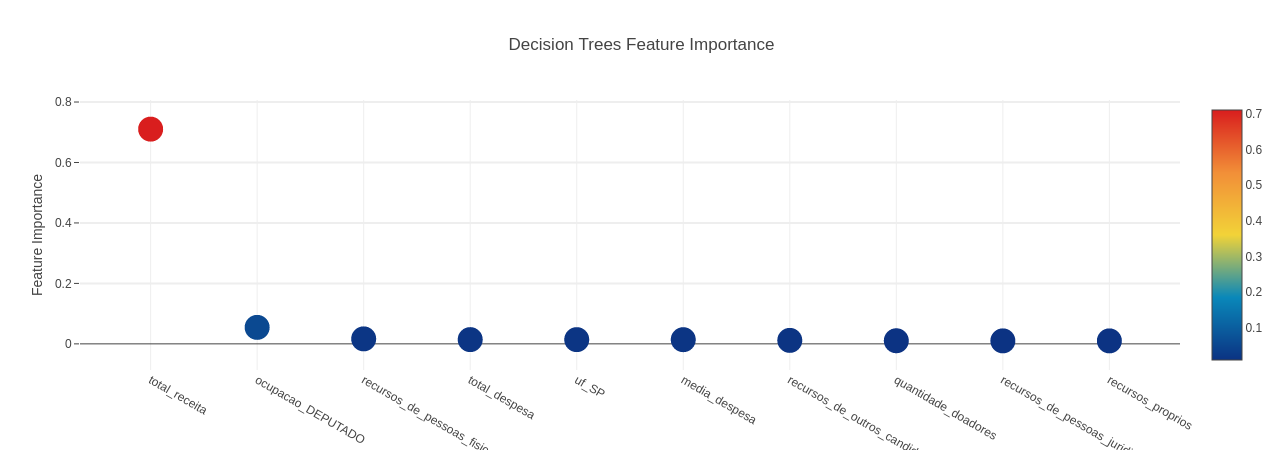

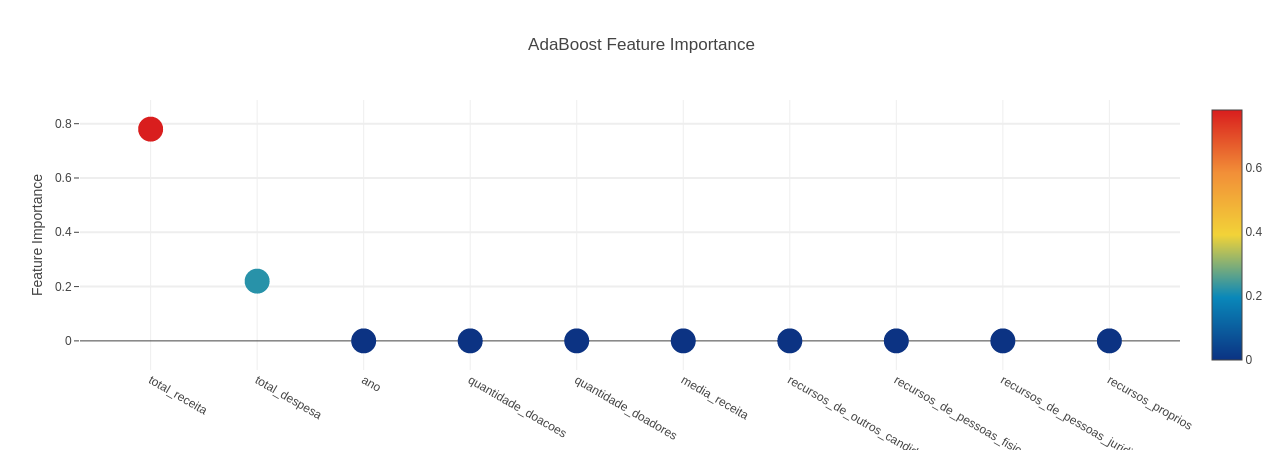

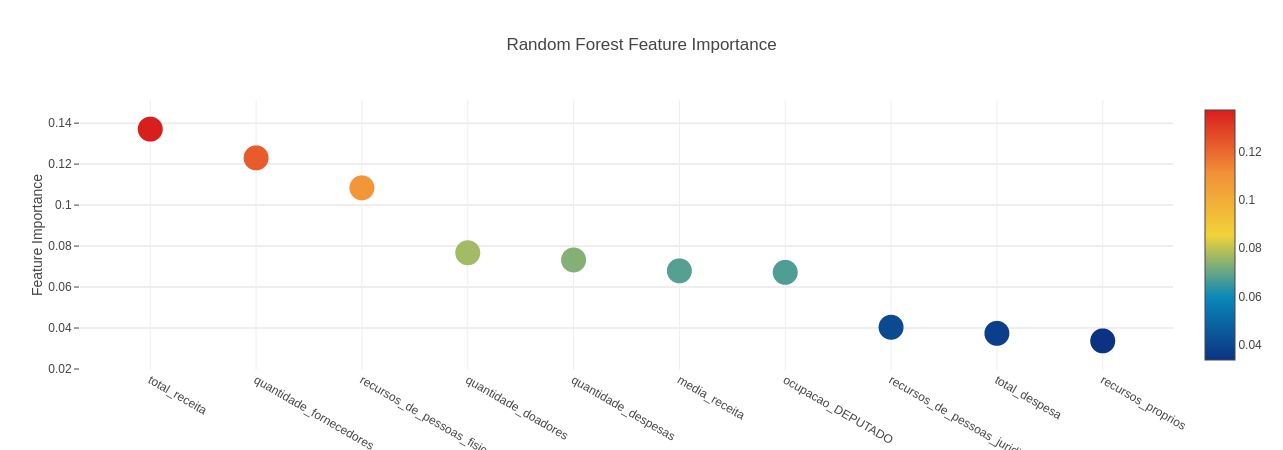

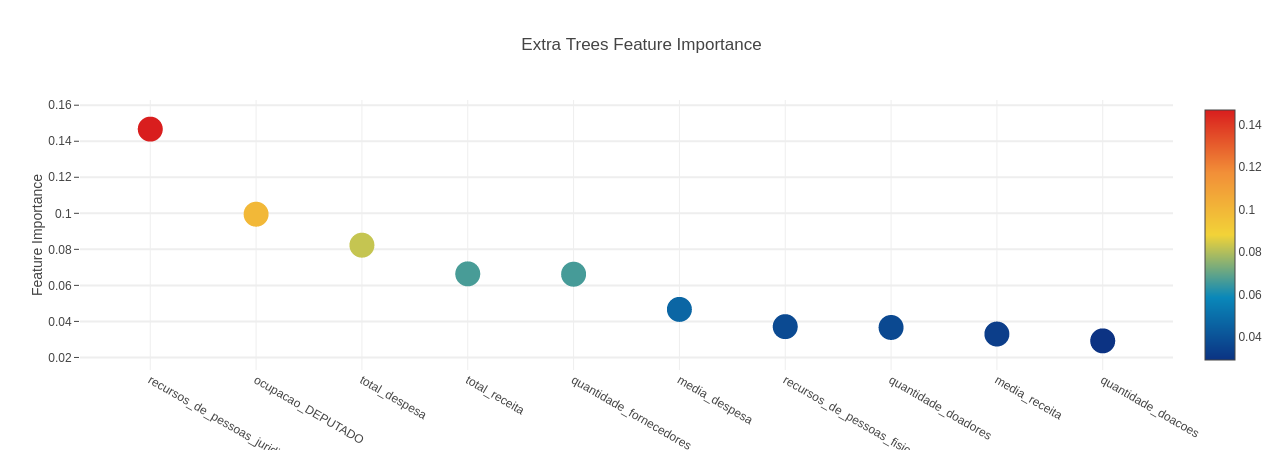

In [56]:
dt   = load_trained_model(ModelsPaths.DT_PATH)
ada  = load_trained_model(ModelsPaths.ADA_PATH)
rf   = load_trained_model(ModelsPaths.RF_PATH)
et   = load_trained_model(ModelsPaths.ET_PATH)

models = [(dt, ModelsNames.DT), (ada, ModelsNames.ADA), (rf, ModelsNames.RF), (et, ModelsNames.ET)]

for model, model_name in models:
    plot_feature_importances_1(model, model_name)

Podemos observar que esses modelos divergem quanto à principal feature que deve ser considerada para que um candidato seja eleito. Entretanto, podemos ver algumas que se repetem e que eles consideram como tendo maior importância:

* total receita
* ocupação Deputado (candidatos tentando reeleição)
* total despesa
* recursos obtidos (pessoas jurídicas, pessoas físicas, etc.)



### Logistic Regression

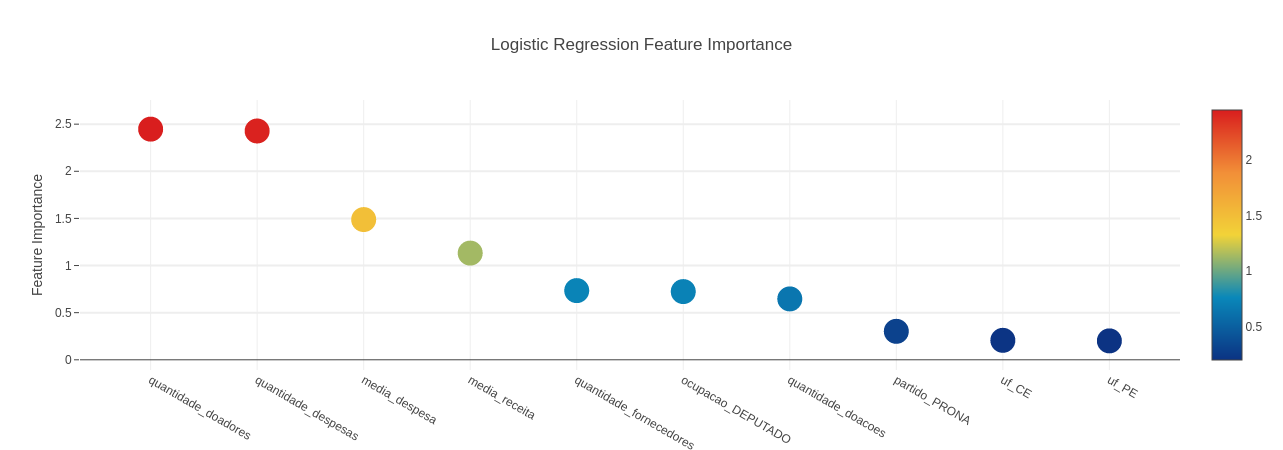

In [100]:
lr   = load_trained_model(ModelsPaths.LR_PATH)
plot_feature_importances(lr, ModelsNames.LR)

### KNR

In [59]:
knr  = load_trained_model(ModelsPaths.KNR_PATH)
svc  = load_trained_model(ModelsPaths.SVC_PATH)
lgbm = load_trained_model(ModelsPaths.LGBM_PATH)
cat  = load_trained_model(ModelsPaths.CAT_PATH)
xgb  = load_trained_model(ModelsPaths.XGB_PATH)

# Second Level Training - Stacking

#### _**Logistic Regression-based Stacking Classifier**_

In [60]:
origin_models = ['knr','lr','dt','ada','rf','svc','et','lgbm','cat','xgb']

stack_df = pd.DataFrame(columns=origin_models + ['oracle'])

stack_df['knr'] = knr.predict_proba(X_test)[:,1]
stack_df['lr'] = lr.predict_proba(X_test)[:,1]
stack_df['dt'] = dt.predict_proba(X_test)[:,1]
stack_df['ada'] = ada.predict_proba(X_test)[:,1]
stack_df['rf'] = rf.predict_proba(X_test)[:,1]
stack_df['svc'] = svc.predict_proba(X_test)[:,1]
stack_df['et'] = et.predict_proba(X_test)[:,1]
stack_df['lgbm'] = lgbm.predict_proba(X_test)[:,1]
stack_df['cat'] = cat.predict_proba(X_test)[:,1]
stack_df['xgb'] = xgb.predict_proba(X_test)[:,1]
stack_df['oracle'] = y_test

stack_df.head()

,knr,lr,dt,ada,rf,svc,et,lgbm,cat,xgb,oracle
0,0.0,1.239188e-01,0.0,0.058540,0.1,5.953742e-02,0.0,0.005581,0.014472,0.018294,0.0
1,1.0,9.104830e-01,1.0,0.813699,0.7,9.596069e-01,1.0,0.925093,0.949038,0.921183,1.0
2,1.0,9.729713e-01,1.0,0.813699,1.0,9.808878e-01,1.0,0.991112,0.994039,0.959468,1.0
3,0.0,3.803377e-14,0.0,0.058540,0.0,3.086599e-07,0.0,0.000066,0.000010,0.001666,0.0
4,1.0,6.782788e-01,1.0,0.813699,0.9,8.052981e-01,1.0,0.997297,0.998765,0.980579,1.0


Previouslly:

* Precision: 0.9481
* Recall: 0.9884
* F1: 0.9679
* Accuracy: 0.9678
* Roc_auc: 0.9682

After add XGBoostClassifier:

* Precision: 0.9658
* Recall: 0.9807
* F1: 0.9732
* Accuracy: 0.9735
* Roc_auc: 0.9736

In [75]:
x__train, x__test, y__train, y__test = train_test_split(stack_df[origin_models], stack_df.oracle, test_size=0.2, random_state=42)

stack_lr = LogisticRegression(solver='liblinear').fit(x__train, y__train)
pred = stack_lr.predict(x__test)

print('Precision: {:.4}'.format(precision_score(y__test, pred)))
print('Recall: {:.4}'.format(recall_score(y__test, pred)))
print('F1: {:.4}'.format(f1_score(y__test, pred)))
print('Accuracy: {:.4}'.format(accuracy_score(y__test, pred)))
print('Roc_auc: {:.4}'.format(roc_auc_score(y__test, pred)))

Precision: 0.9625
Recall: 0.9923
F1: 0.9772
Accuracy: 0.9773
Roc_auc: 0.9776


## EXTRA - Usando Pipelines e GridSearch do Scikit Learn

Abaixo nós fazemos alguns pipelines e grid searches com os mesmos algoritmos usados acima com o intuito de checar se os valores obtidos são correspondentes.

### Conclusão

Como se observa acima, o melhor modelo encontrado foi o modelo **Lasso Regressor** em termos de RMSE, com o modelo **Ridge Regressor** bem próximo dele em termos de RMSE.

Entretanto os valores de RMSE são distintos dos valores encontrados acima. Isso pode se dever ao ajuste dos parâmetros dos modelos, feitos durante a própria busca, e/ou por alguma diferença na função de scoring, que talvez tenha passado despercebida pela nossa análise.